<a href="https://colab.research.google.com/github/IkutoYoshioka/AI-/blob/main/Store_Sales_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

train = pd.read_csv('drive/MyDrive/kaggle/Store Sales-Time Series Forecasting/train.csv')
test = pd.read_csv('drive/MyDrive/kaggle/Store Sales-Time Series Forecasting/test.csv')
store_data = pd.read_csv('drive/MyDrive/kaggle/Store Sales-Time Series Forecasting/stores.csv')
oil_data = pd.read_csv('drive/MyDrive/kaggle/Store Sales-Time Series Forecasting/oil.csv')
holiday_data = pd.read_csv('drive/MyDrive/kaggle/Store Sales-Time Series Forecasting/holidays_events.csv')
transaction_data = pd.read_csv('drive/MyDrive/kaggle/Store Sales-Time Series Forecasting/transactions.csv')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
# merge (except holiday_data)

merge1 = pd.merge(train, oil_data, on='date', how='left')
merge2 = pd.merge(merge1, transaction_data, on=['date', 'store_nbr'], how='left')
merge3 = pd.merge(merge2, store_data, on='store_nbr', how='left')

merge3.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,transactions,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,NaN,Quito,Pichincha,D,13


In [5]:
holiday_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [6]:
# drop 'transferred == True' and 'locale != National' ==> description を残す

holiday_data = holiday_data[holiday_data.transferred != True]
holiday_data = holiday_data[holiday_data.locale == 'National']

holiday_data = holiday_data.drop(columns = ['type', 'locale', 'locale_name', 'transferred'])

In [7]:
# merge3 + national holiday

merge4 = pd.merge(merge3, holiday_data, on='date', how='left')
merge4.rename(columns={'description' : 'holiday'}, inplace=True)

df = merge4
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,transactions,city,state,type,cluster,holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,NaN,Quito,Pichincha,D,13,Primer dia del ano
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,NaN,Quito,Pichincha,D,13,Primer dia del ano
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,NaN,Quito,Pichincha,D,13,Primer dia del ano
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,NaN,Quito,Pichincha,D,13,Primer dia del ano
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,NaN,Quito,Pichincha,D,13,Primer dia del ano


In [8]:
df.info()
df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008016 entries, 0 to 3008015
Data columns (total 13 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   int64  
 6   dcoilwtico    float64
 7   transactions  float64
 8   city          object 
 9   state         object 
 10  type          object 
 11  cluster       int64  
 12  holiday       object 
dtypes: float64(3), int64(4), object(6)
memory usage: 298.3+ MB


,id,store_nbr,sales,onpromotion,dcoilwtico,transactions,cluster
count,3008016.00,3008016.00,3008016.00,3008016.00,2074248.00,2761935.00,3008016.00
mean,1501507.63,27.50,358.27,2.61,67.91,1695.50,8.48
std,865730.31,15.59,1103.51,12.26,25.66,964.18,4.65
min,0.00,1.00,0.00,0.00,26.19,5.00,1.00
25%,752003.75,14.00,0.00,0.00,46.39,1046.00,4.00
50%,1502225.50,27.50,11.00,0.00,53.36,1394.00,8.50
75%,2248883.25,41.00,196.00,0.00,95.78,2080.00,13.00
max,3000887.00,54.00,124717.00,741.00,110.62,8359.00,17.00


In [9]:
df.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
dcoilwtico       933768
transactions     246081
city                  0
state                 0
type                  0
cluster               0
holiday         2758536
dtype: int64

In [10]:
# null oil price を埋める

def oil_nulls(x):
  if x.notnull().sum() > 1:
    return x.interpolate().ffill().bfill()
  else:
    return x.ffill().bfill()

df['dcoilwtico'] = oil_nulls(df['dcoilwtico'])
df.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
dcoilwtico            0
transactions     246081
city                  0
state                 0
type                  0
cluster               0
holiday         2758536
dtype: int64

In [11]:
# year,month,day,day_name

def date_features(x):
  x['date'] = pd.to_datetime(x['date'])

  x['year'] = x['date'].dt.year
  x['month'] = x['date'].dt.month
  x['day'] = x['date'].dt.day
  x['day_name'] = x['date'].dt.day_name()
  return x

df = date_features(df)
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,transactions,city,state,type,cluster,holiday,year,month,day,day_name
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,NaN,Quito,Pichincha,D,13,Primer dia del ano,2013,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,NaN,Quito,Pichincha,D,13,Primer dia del ano,2013,1,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,NaN,Quito,Pichincha,D,13,Primer dia del ano,2013,1,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,NaN,Quito,Pichincha,D,13,Primer dia del ano,2013,1,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,NaN,Quito,Pichincha,D,13,Primer dia del ano,2013,1,1,Tuesday


In [12]:
# サンプル抽出

df1 = df.sample(n=300000).reset_index()

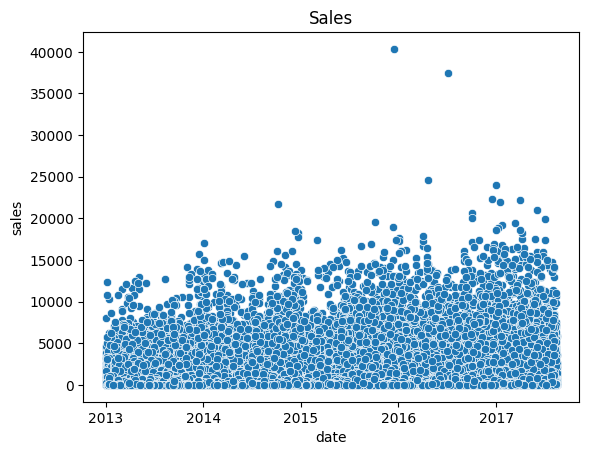

In [13]:
ax = sns.scatterplot(data=df1, x='date', y='sales')
ax.set_title('Sales')
plt.show()

In [14]:
# 外れ値処理

for i in range(1,len(df.store_nbr.unique())+1):
  val = df[df.store_nbr == i].sales.quantile(0.99)
  df = df.drop(df[(df.store_nbr == i) & (df.sales > val)].index)

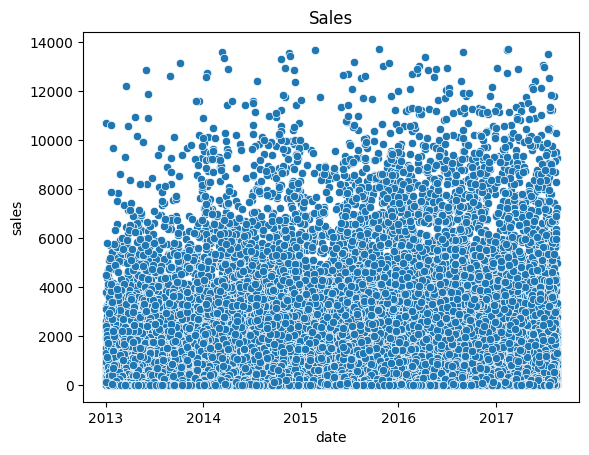

In [15]:
# 再サンプル抽出

df1 = df.sample(n=300000).reset_index()

ax = sns.scatterplot(data=df1, x='date', y='sales')
ax.set_title('Sales')
plt.show()

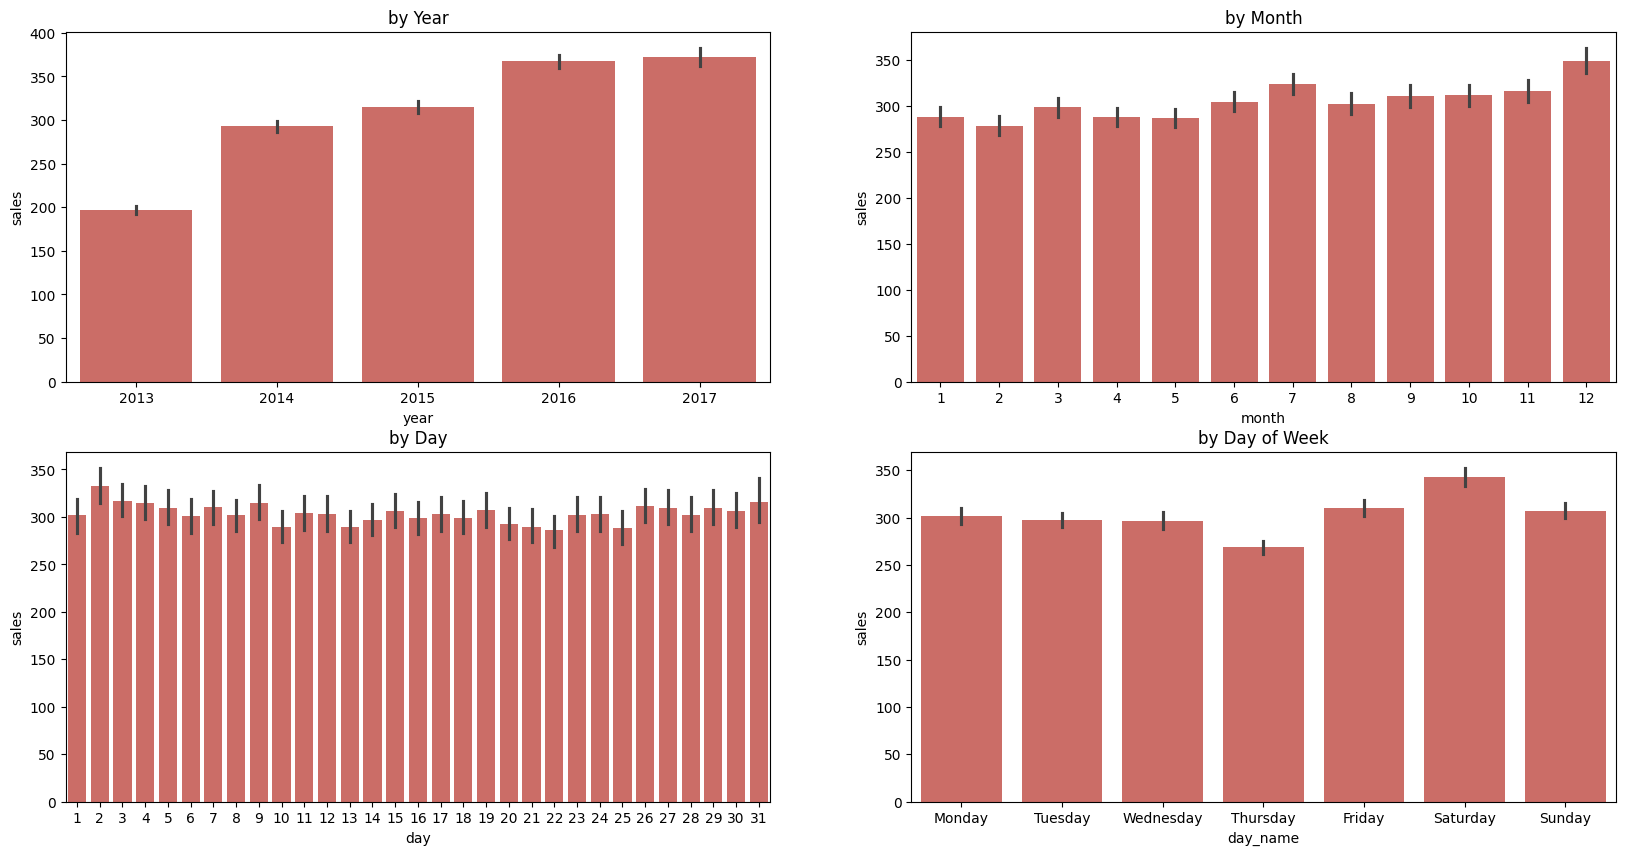

In [16]:
# 売上データをみる

order =['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.set_palette('hls')
fig, axs = plt.subplots(2, 2, figsize=(20,10))

sns.barplot(x='year', y='sales', data=df1, ax=axs[0,0])
sns.barplot(x='month', y='sales', data=df1, ax=axs[0,1])
sns.barplot(x='day', y='sales', data=df1, ax=axs[1,0])
sns.barplot(x='day_name', y='sales', data=df1, ax=axs[1,1], order=order)

axs[0,0].set_title('by Year')
axs[0,1].set_title('by Month')
axs[1,0].set_title('by Day')
axs[1,1].set_title('by Day of Week')
plt.show()

### Observations:


1.   2013-2017にかけて売上が増加
2.   12月に売上が多い
3.   月初めに売上が多い
4.   週末に売上が多い



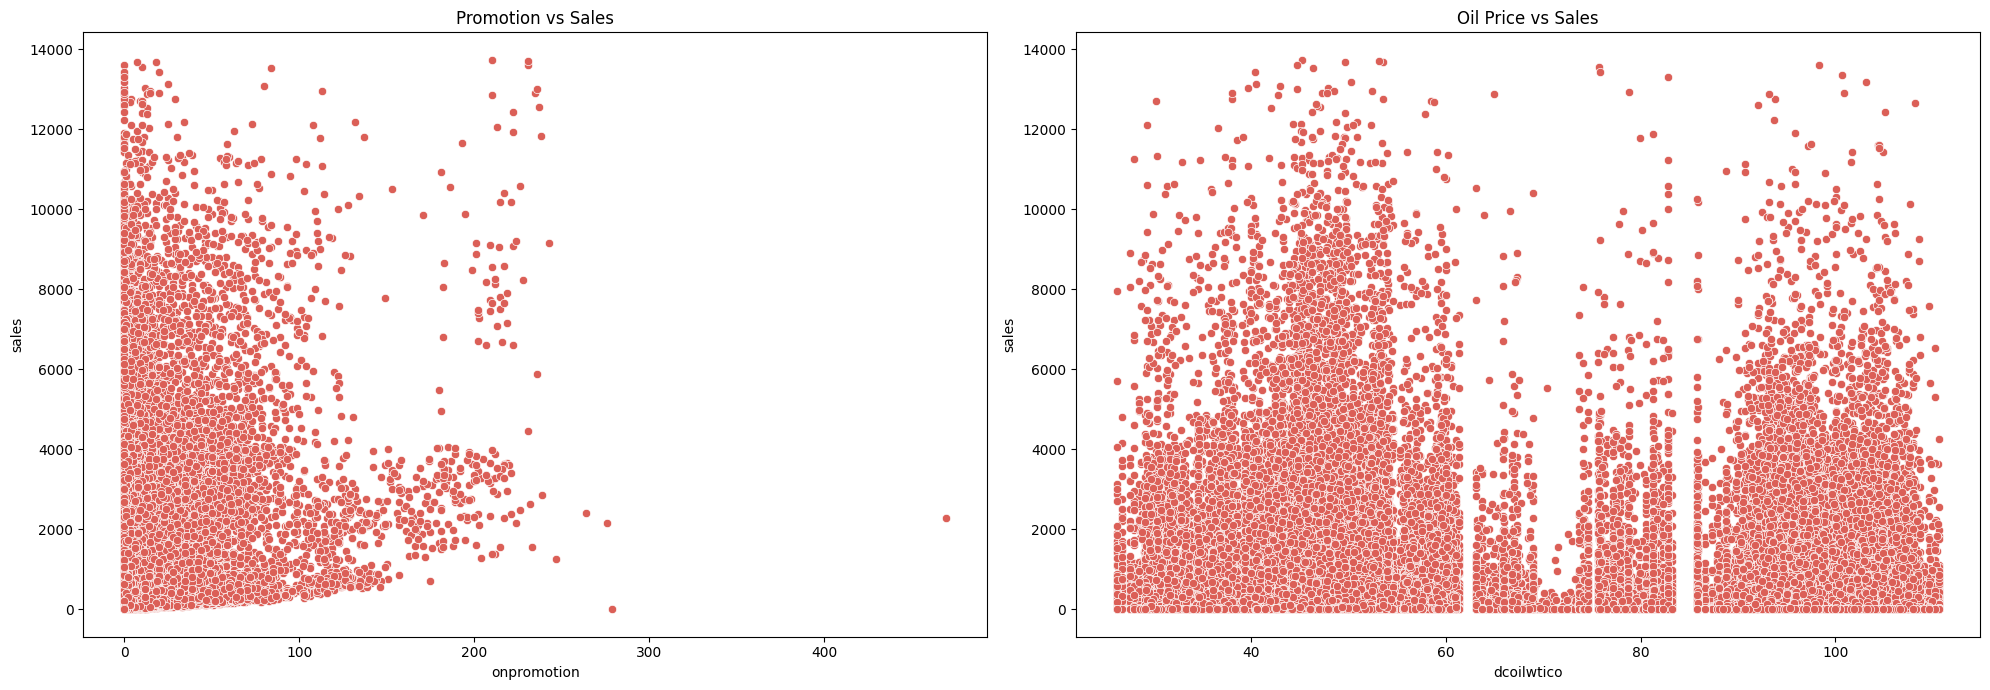

In [17]:
# promotionとoil priceの売上への影響

fig, axs = plt.subplots(1, 2, figsize=(20,7))

sns.scatterplot(data=df1, x='onpromotion', y='sales', ax=axs[0])
ax = sns.scatterplot(data=df1, x='dcoilwtico', y='sales', ax=axs[1])

axs[0].set_title('Promotion vs Sales')
axs[1].set_title('Oil Price vs Sales')

plt.tight_layout()
plt.show()

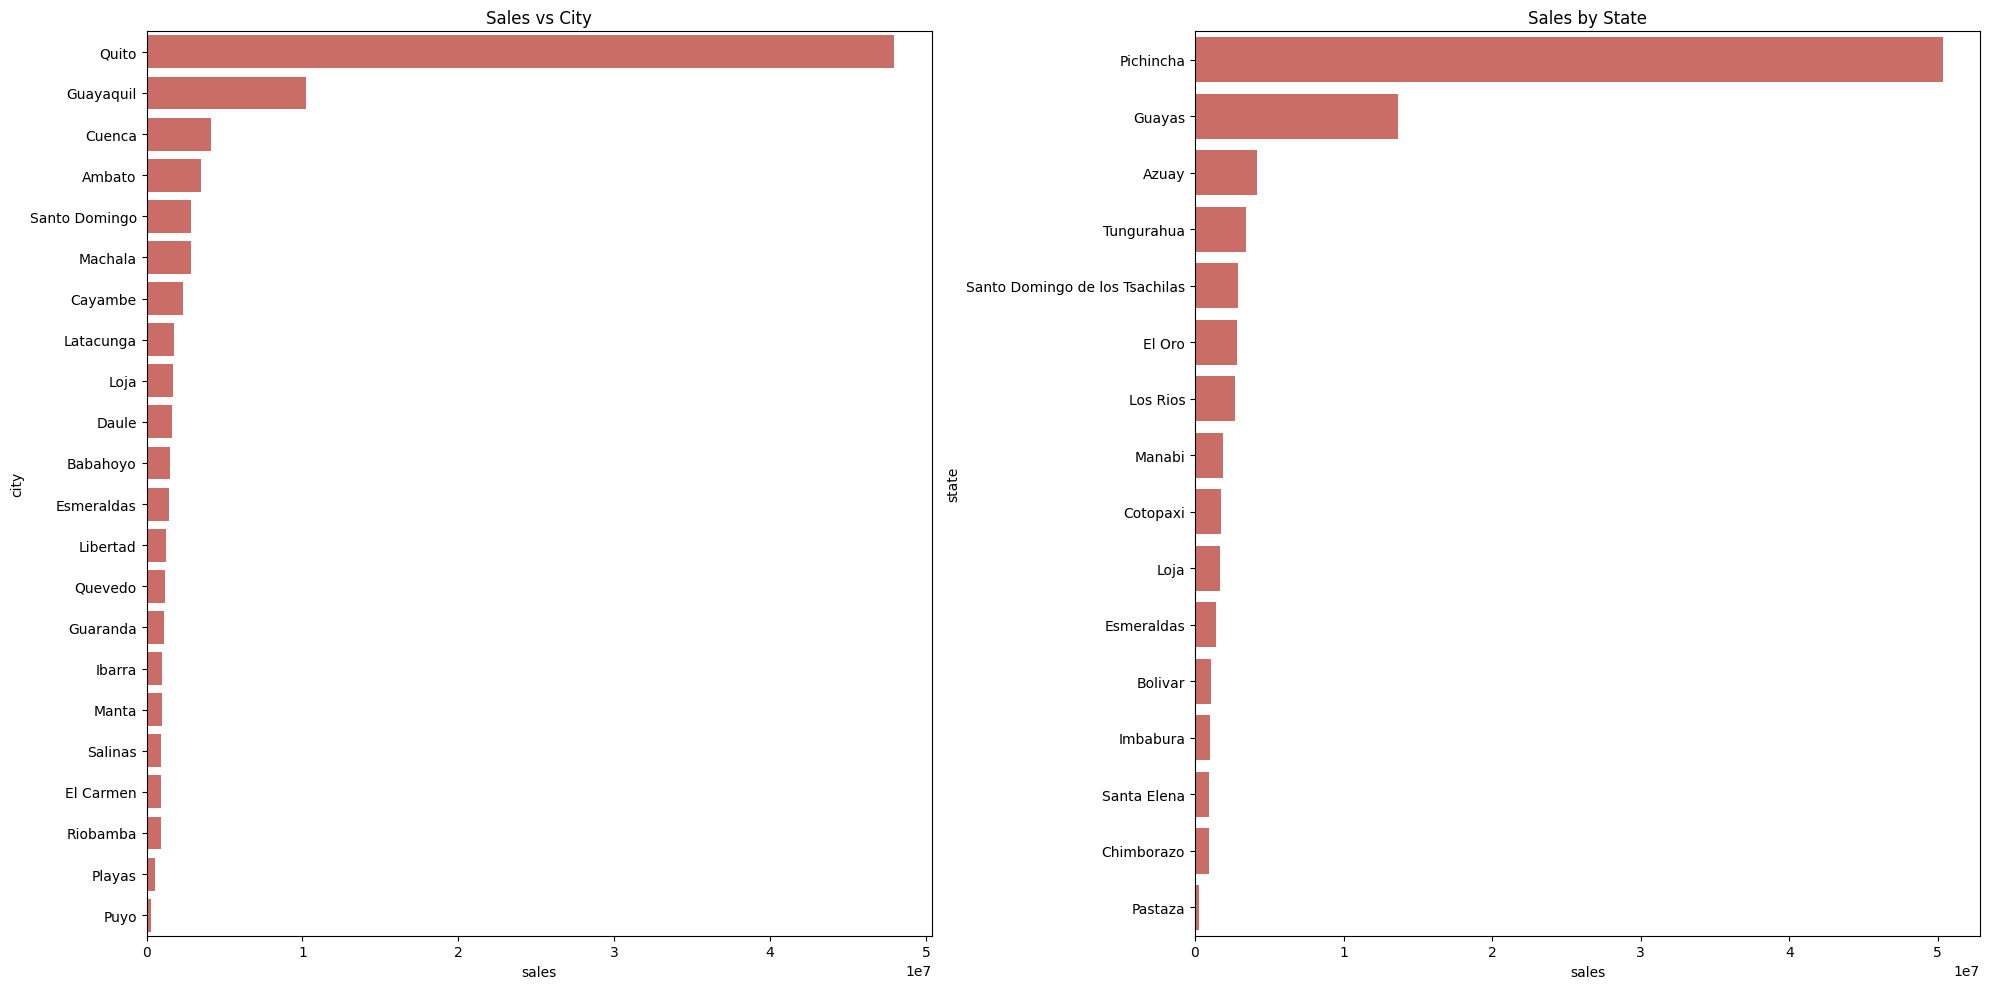

In [18]:
# 最多売上都市

fig, axs = plt.subplots(1, 2, figsize=(20,10))

sns.barplot(x='sales', y='city', data=df1.groupby('city')['sales'].sum().reset_index().sort_values('sales', ascending = False), ax=axs[0])
sns.barplot(x='sales', y='state', data=df1.groupby('state')['sales'].sum().reset_index().sort_values('sales', ascending = False), ax=axs[1])

axs[0].set_title('Sales vs City')
axs[1].set_title('Sales by State')

plt.tight_layout()
plt.show()

In [19]:
# family

np.sort(df.family.unique())

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [20]:
# sum of sales
familypivot = pd.DataFrame()
familypivot = df.groupby(by='family')['sales'].sum().sort_values(ascending=False).reset_index()
familypivot.head()

# percentage of sales
total = familypivot['sales'].sum()
familypivot['percentage'] = (familypivot['sales']/total)

familypivot.head()

,family,sales,percentage
0,GROCERY I,2.198273e+08,0.244178
1,BEVERAGES,1.843857e+08,0.204811
2,PRODUCE,1.055710e+08,0.117265
3,CLEANING,9.715241e+07,0.107914
4,DAIRY,6.462747e+07,0.071786


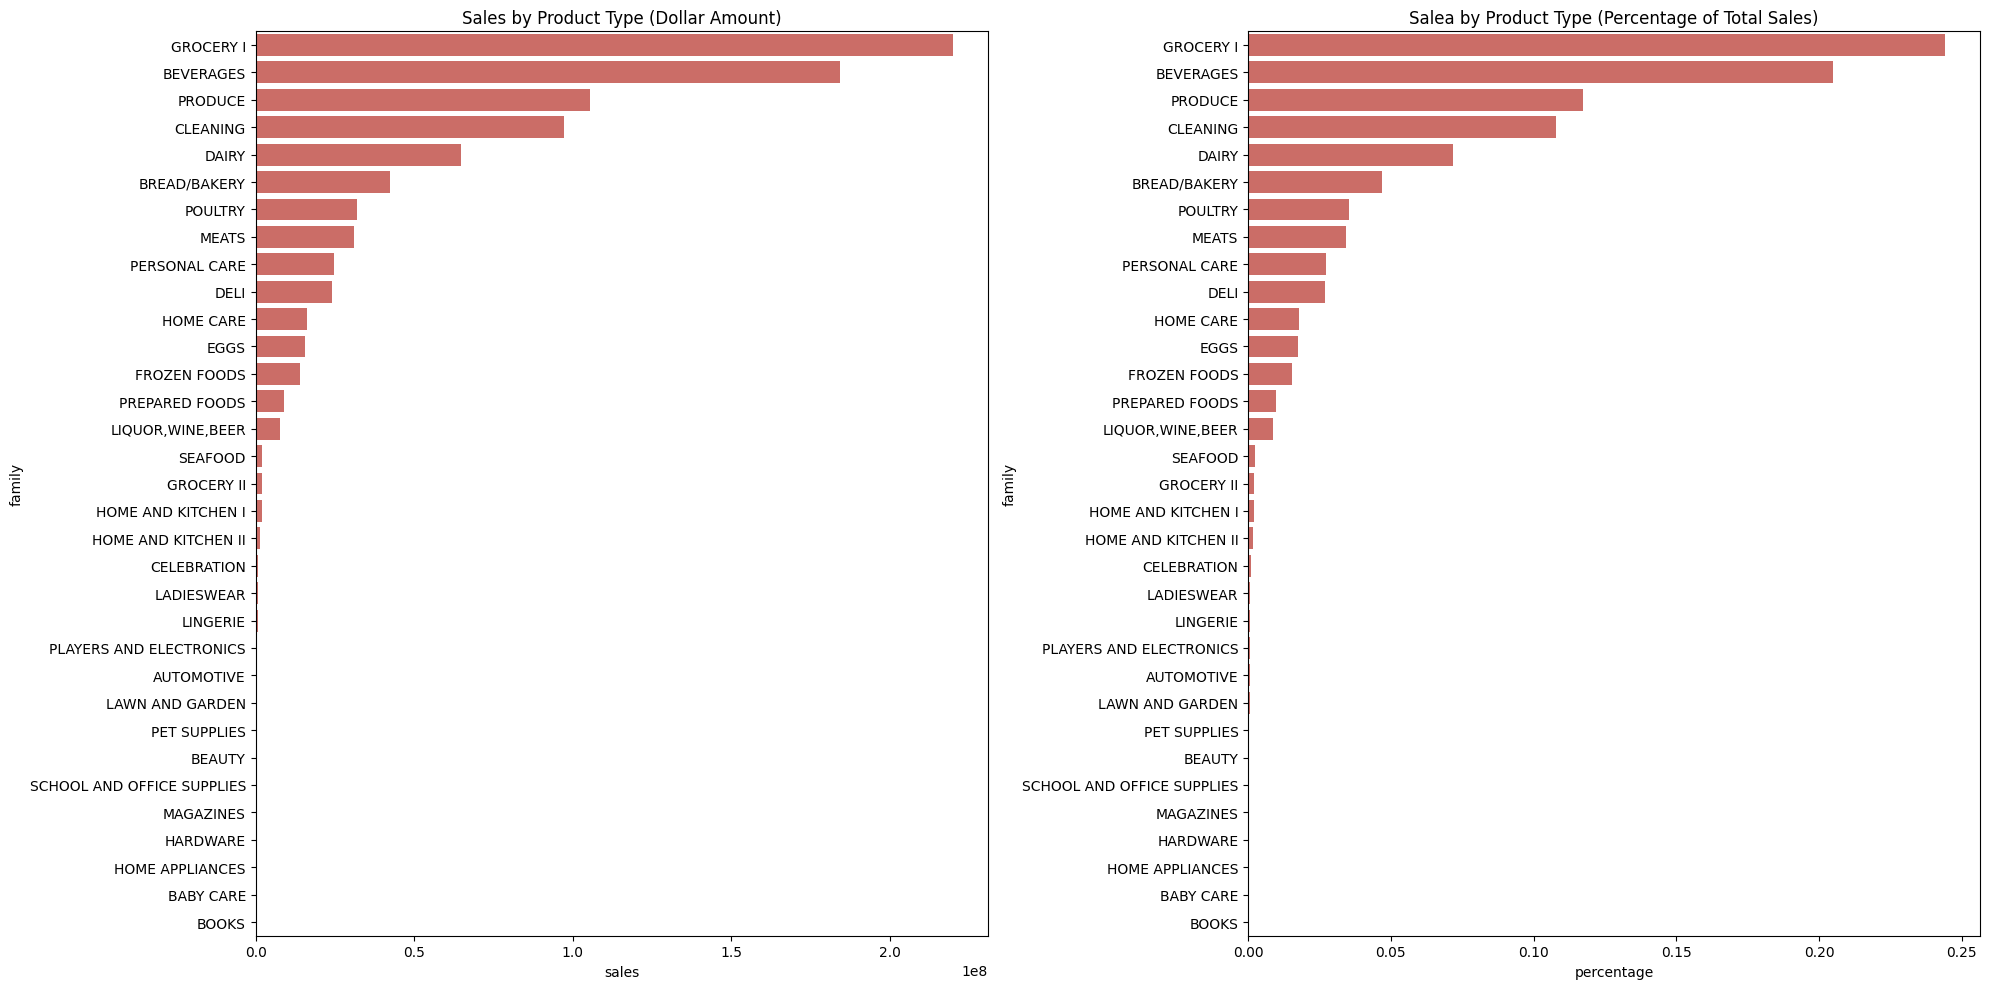

In [21]:
# visualize

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

sns.barplot(data=familypivot, x='sales', y='family', ax=axs[0])
sns.barplot(data=familypivot, x='percentage', y='family', ax=axs[1])

axs[0].set_title('Sales by Product Type (Dollar Amount)')
axs[1].set_title('Salea by Product Type (Percentage of Total Sales)')

plt.tight_layout()
plt.show()

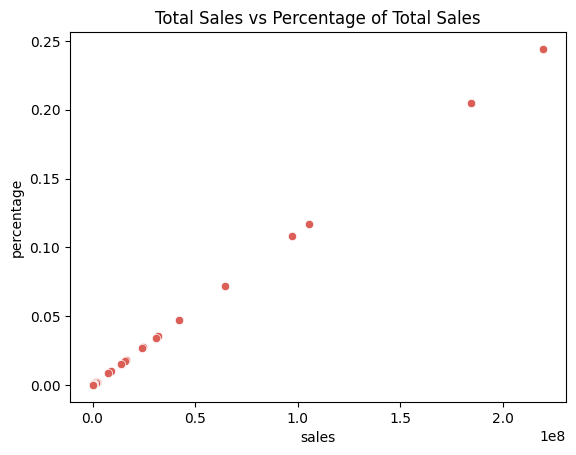

In [22]:
ax = sns.scatterplot(data=familypivot, x='sales', y='percentage')
ax.set_title('Total Sales vs Percentage of Total Sales')

plt.show()

In [23]:
family_map       = {'AUTOMOTIVE': 'rest',
                   'BABY CARE': 'rest',
                   'BEAUTY': 'rest',
                   'BOOKS': 'rest',
                   'CELEBRATION': 'rest',
                   'GROCERY II': 'rest',
                   'HARDWARE': 'rest',
                   'HOME AND KITCHEN I': 'rest',
                   'HOME AND KITCHEN II': 'rest',
                   'HOME APPLIANCES': 'rest',
                   'LADIESWEAR': 'rest',
                   'LAWN AND GARDEN': 'rest',
                   'LINGERIE': 'rest',
                   'MAGAZINES': 'rest',
                   'PET SUPPLIES': 'rest',
                   'PLAYERS AND ELECTRONICS': 'rest',
                   'SCHOOL AND OFFICE SUPPLIES': 'rest','SEAFOOD': 'rest',
                   'DELI': 'fifth',
                    'EGGS': 'sixth',
                    'FROZEN FOODS': 'sixth',
                    'HOME CARE': 'sixth',
                    'LIQUOR,WINE,BEER': 'sixth',
                    'PREPARED FOODS': 'sixth',
                    'PERSONAL CARE': 'fifth',
                    'BREAD/BAKERY': 'fourth',
                    'MEATS': 'fifth',
                    'POULTRY': 'third',
                    'CLEANING':'third',
                    'DAIRY':'fourth',
                    'PRODUCE':'third',
                    'BEVERAGES':'second',
                    'GROCERY I': 'first'
                   }

df['new_family'] = df['family'].map(family_map)
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,transactions,city,state,type,cluster,holiday,year,month,day,day_name,new_family
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,NaN,Quito,Pichincha,D,13,Primer dia del ano,2013,1,1,Tuesday,rest
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,NaN,Quito,Pichincha,D,13,Primer dia del ano,2013,1,1,Tuesday,rest
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,NaN,Quito,Pichincha,D,13,Primer dia del ano,2013,1,1,Tuesday,rest
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,NaN,Quito,Pichincha,D,13,Primer dia del ano,2013,1,1,Tuesday,second
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,NaN,Quito,Pichincha,D,13,Primer dia del ano,2013,1,1,Tuesday,rest


In [24]:
# drop the old family column

df2 = df.drop(columns=['family'])
df2.head()

,id,date,store_nbr,sales,onpromotion,dcoilwtico,transactions,city,state,type,cluster,holiday,year,month,day,day_name,new_family
0,0,2013-01-01,1,0.0,0,93.14,NaN,Quito,Pichincha,D,13,Primer dia del ano,2013,1,1,Tuesday,rest
1,1,2013-01-01,1,0.0,0,93.14,NaN,Quito,Pichincha,D,13,Primer dia del ano,2013,1,1,Tuesday,rest
2,2,2013-01-01,1,0.0,0,93.14,NaN,Quito,Pichincha,D,13,Primer dia del ano,2013,1,1,Tuesday,rest
3,3,2013-01-01,1,0.0,0,93.14,NaN,Quito,Pichincha,D,13,Primer dia del ano,2013,1,1,Tuesday,second
4,4,2013-01-01,1,0.0,0,93.14,NaN,Quito,Pichincha,D,13,Primer dia del ano,2013,1,1,Tuesday,rest


In [25]:
def replace_non_null(x):
  x.loc[x['holiday'].notnull(), 'holiday'] = 'yes'
  return x

df2 = replace_non_null(df2)

In [26]:
df2.head()

,id,date,store_nbr,sales,onpromotion,dcoilwtico,transactions,city,state,type,cluster,holiday,year,month,day,day_name,new_family
0,0,2013-01-01,1,0.0,0,93.14,NaN,Quito,Pichincha,D,13,yes,2013,1,1,Tuesday,rest
1,1,2013-01-01,1,0.0,0,93.14,NaN,Quito,Pichincha,D,13,yes,2013,1,1,Tuesday,rest
2,2,2013-01-01,1,0.0,0,93.14,NaN,Quito,Pichincha,D,13,yes,2013,1,1,Tuesday,rest
3,3,2013-01-01,1,0.0,0,93.14,NaN,Quito,Pichincha,D,13,yes,2013,1,1,Tuesday,second
4,4,2013-01-01,1,0.0,0,93.14,NaN,Quito,Pichincha,D,13,yes,2013,1,1,Tuesday,rest


In [27]:
# x,yを分離

from sklearn.model_selection import train_test_split

X, y = df2.drop('sales', axis=1), df2[['sales']]

In [28]:
# non-numerical columns into categorical data type

cats = X.select_dtypes(exclude=np.number).columns.tolist()

for col in cats:
  X[col] = X[col].astype('category')

X.dtypes

id                 int64
date            category
store_nbr          int64
onpromotion        int64
dcoilwtico       float64
transactions     float64
city            category
state           category
type            category
cluster            int64
holiday         category
year               int32
month              int32
day                int32
day_name        category
new_family      category
dtype: object

In [29]:
# split data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [38]:
import xgboost as xgb

dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [40]:
from sklearn.metrics import mean_squared_error

params = {'objective':'reg:squarederror'}
evals = [(dtrain_reg, 'train'), (dtest_reg, 'validation')]
n = 5000

model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=250,
    early_stopping_rounds=50
)

preds = model.predict(dtest_reg)

rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE: {rmse:.3f}")

[0]	train-rmse:670.36026	validation-rmse:675.33456
[248]	train-rmse:219.97495	validation-rmse:296.29460
RMSE: 296.295


In [41]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [42]:
merge1 = pd.merge(test, oil_data, on='date', how='left')
merge2 = pd.merge(merge1, transaction_data, on=['date', 'store_nbr'], how='left')
merge3 = pd.merge(merge2, store_data, on='store_nbr', how='left')

merge4 = pd.merge(merge3, holiday_data, on='date', how='left')
merge4.rename(columns={'description':'holiday'}, inplace=True)

test1 = merge4

test1['dcoilwtico'] = oil_nulls(test1['dcoilwtico'])
test1 = date_features(test1)

test1['new_family'] = test1['family'].map(family_map)
test1 = test1.drop(columns=['family'])

test1 = replace_non_null(test1)

test1.head()

,id,date,store_nbr,onpromotion,dcoilwtico,transactions,city,state,type,cluster,holiday,year,month,day,day_name,new_family
0,3000888,2017-08-16,1,0,46.8,NaN,Quito,Pichincha,D,13,NaN,2017,8,16,Wednesday,rest
1,3000889,2017-08-16,1,0,46.8,NaN,Quito,Pichincha,D,13,NaN,2017,8,16,Wednesday,rest
2,3000890,2017-08-16,1,2,46.8,NaN,Quito,Pichincha,D,13,NaN,2017,8,16,Wednesday,rest
3,3000891,2017-08-16,1,20,46.8,NaN,Quito,Pichincha,D,13,NaN,2017,8,16,Wednesday,second
4,3000892,2017-08-16,1,0,46.8,NaN,Quito,Pichincha,D,13,NaN,2017,8,16,Wednesday,rest


In [43]:
cats = test1.select_dtypes(exclude=np.number).columns.tolist()

for col in cats:
  test1[col] = test1[col].astype('category')

In [44]:
test1_matrix = xgb.DMatrix(test1, enable_categorical=True)
predictions = model.predict(test1_matrix)
test1['sales'] = predictions
test1['sales'] = test1['sales'].clip(lower=0)

In [45]:
test1 = test1.drop(columns=['date', 'store_nbr', 'onpromotion', 'dcoilwtico', 'transactions',
                            'city', 'state', 'type', 'cluster', 'holiday',
                            'year', 'month', 'day', 'day_name', 'new_family'])

test1.head()

,id,sales
0,3000888,5.761532
1,3000889,5.761532
2,3000890,0.000000
3,3000891,2044.336670
4,3000892,5.761532


In [48]:
sample = pd.read_csv('drive/MyDrive/kaggle/Store Sales-Time Series Forecasting/sample_submission.csv')

In [49]:
test1.to_csv('submission.csv', index=False)